#Sparse Coding with Keras

When I start using a new machine learning library I usually write a Sparse Coding class to get a feeling of how its pieces work together.  
In this post I'll show how I did that with [Keras](http://keras.io) Theano-based Deep learning library. But first, let us review what sparse coding means.

###Sparse coding

Sparse coding is an unsupervised learning technique, thus it is statistical model of data. In its most simple form, sparse coding represents the input data $\mathbf{s}$ as a linear model:  

\begin{equation}
\mathbf{s} \approx \mathbf{Ax},  
\end{equation}

where $\mathbf{A}$ are a set of basis functions and $\mathbf{x}$ a sparse vector of linear coefficients. In practice, given a dataseset $\mathbf{S=\{s_1, ..., s_n\}}$ we can estimate the $\mathbf{A}$ and $\mathbf{X={x_1, ..., x_n}}$ alternating the expection of the coefficients $\mathbf{x}_i$ and the maximization of $\mathbf{A}$. We do so by minimizing the following cost function:

\begin{equation}
\mathcal{L} = E\left[ (\mathbf{s}_i - \mathbf{Ax}_i)^2 + \gamma\left|\mathbf{x}_i \right|_{L1} \right],
\end{equation}

where $E[\cdot]$ denotes the expectataion operator, $\left| \cdot \right|_{L1}$ the L1-norm and $\gamma$ is a penalty constant. 

The different sparse coding techniques differ on how they do previous optimization. Here, I will focus on a fully differentiable one [1] that allows us to use sparse coding as a layer of a deep neural network. For instance, I will approximate the L1-norm as $|x|_{L1} \approx \sqrt{x^2 + 10^{-7}}$. We will skip talking about the precise gradients here, because Theano will handle that for us automatically. But notice that the Expectation-Maximization (EM) of $\mathcal{L}$ alternates a few steps of gradient descent for $\mathbf{x}_i$:

\begin{equation}
\mathbf{x}_i \leftarrow \mathbf{x}_i + \eta_x\frac{\partial \mathcal{L}}{\partial \mathbf{x}_i}
\end{equation}

and a step for $\mathbf{A}$

\begin{equation}
\mathbf{A} \leftarrow \mathbf{A} + \eta_A \frac{\partial \mathcal{L}}{\partial \mathbf{A}}.
\end{equation}

And here is where our design choices start. Lets see how to go about that with Theano and Keras.

###A new Keras layer

A minimal Keras layer needs only two methods:

In [ ]:
class SparseCoding(Layer):
    def __init__(self, input_dim, output_dim,
                 init='glorot_uniform',
                 activation='linear',
                 truncate_gradient=-1,
                 gamma=.1, # 
                 n_steps=10,
                 batch_size=100,
                 return_reconstruction=False,
                 W_regularizer=l2(.01),
                 activity_regularizer=None):):
            
            super(SparseCoding, self).__init__()
            self.init = init
            ...
            
            self.A = self.init((self.output_dim, self.input_dim)) # contrary to a regular neural net layer, here 
                                                                  # the output needs to have the same dimension as
                                                                  # as the input we are modelling. Other layers would
                                                                  # have self.init((self.input_dim, self.output_dim))
                                                                  # as the dimensions of its adaptive coefficients.

    def get_output(self, train=False):
        ...

The `get_output` method is the feedforward step of the layer. I chose this to be the Expectation (optimization for \mathbf{x}) of the sparse coding. Notice that we need to do a few steps of optimization for $\mathbf{x}$ before we consider doing an step for $\mathbf{A}$. This is to give the sparse codes enough time to converge. Thus, we will need a sort of for loop inside our `get_output`. In Theano, for loops are implemented with [scan](http://deeplearning.net/software/theano/library/scan.html). 

Theano's `scan` is composed of a `step` function, which is the main operation to transform old states into new ones and a few sequential and non-sequential parameters along with initial states values. So, here is how we define our `get_output`. 

In [5]:
def get_output(self, train=False):
    s = self.get_input(train) # input data to be modeled
    initial_x = alloc_zeros_matrix(self.batch_size, self.output_dim) # initialize sparse codes with zeros.
                                                                     # Again note that the coefficients here got 
                                                                     # output_dim as its last dimension because this 
                                                                     # a generative model.
    outputs, updates = theano.scan(
            self._step, # function operated in the main loop
            sequences=[], # iterable input sequences, we don't need this here
            outputs_info=[initial_states, ]*3 + [None, ], # initial states, I'll explain why we have 4 initial states.
            non_sequences=[inputs, prior], # this is kept the same for the entire for loop
            n_steps=self.n_steps, # since sequences is empty, scan needs this information to know when to stop
            truncate_gradient=self.truncate_gradient) # how much backpropagation throught time/iteration you need.
    if self.return_reconstruction:
            return outputs[-1][-1] # return the approximation of the input
    else:
            return outputs[0][-1] # return the sparse codes

This is basically the outter definition of a for loop. The following `_step` function defines what happens inside:

In [7]:
def _step(self, 
          x_t, # this is the code itself at the begging of the Expectation step. First values are zero, remember?
          accum_1, # We are not going to use regular SGD to optimize 
          accum_2, # for x. It is too slow, we will use RMSprop instead. Those are its internal helper variables.
          inputs # Fixed input data
          ): 
        outputs = T.dot(x_t, self.A) # Ax, its faster to use row orientation here, C heritage you know?
        rec_error = T.sqr(inputs - outputs).sum() # First right hand term of L (s - Ax)^2
        l1_norm = (self.gamma * diff_abs(x_t)).sum() # diff_abs is sqrt(x^2 + 1e-7) we were talking about
        cost = rec_error + l1_norm # this the cost function L
        x, new_accum_1, new_accum_2 = _RMSPropStep(cost, x_t, accum_1, accum_2) # _RMSPropStep does the step
                                                                                # optimization x <- x + n*grad(L,x)
        return x, new_accum_1, new_accum_2, outputs

Here is how we will use [RMSprop](https://www.youtube.com/watch?v=LGA-gRkLEsI) to speed up the optimization of $\mathbf{x}$.

In [9]:
def _RMSPropStep(cost, states, accum_1, accum_2):
    rho = .9 # Nobody 
    lr = .001 # usually understand
    momentum = .9 # or mess
    epsilon = 1e-8 # with those hyperparameters. BTW lr is the learning rate.

    grads = T.grad(cost, states) # I love Theano, don't you
    
    # Did you see the video I linked above? Ok, keep reading
    new_accum_1 = rho * accum_1 + (1 - rho) * grads**2 # running average
    new_accum_2 = momentum * accum_2 - lr * grads / T.sqrt(new_accum_1 + epsilon) # momentum
    new_states = states + momentum * new_accum_2 - lr * (grads /                        # This is the actual grad
                                                         T.sqrt(new_accum_1 + epsilon)) # step update
    return new_states, new_accum_1, new_accum_2

And thats all we need. Notice that effectively, a sparse coding layer is a recursive layer, similar to an RNN layer. Here we can backpropagate the gradients thorugh optimization step to optimize for $\mathbf{A}$. Theano `grad` does that backpropagating thorough `scan`. Thus, the Maximization step of the EM-algorithm will be handled by Keras's optimization and I didn't need to write anything for that.

A Sparse Coding layer is available as part of `Seya` a library that I'm writing as a companion to Keras. Lets give it a try next.

### Hands on example

Assuming you already have Anaconda (or something like that), scikit-learn, Keras, and stuff. Just install a few extra things I'm writing. 

Seya for sparse coding layers:  

        pip install git+https://github.com/EderSantana/seya.git   
        
Agnez for deep learning viz stuff. This will be great one day... one day:  

        pip install git+https://github.com/EderSantana/agnez.git  
        
Install the extra stuff your enviroment may ask. Like Seaborn: `pip install seaborn`. Also download a dataset of natural image patches to use here

In [1]:
# Download a natural image patches dataset
%matplotlib inline
import os
import numpy as np
#from scipy.io import loadmat
#os.system('wget http://cs.stanford.edu/~jngiam/data/patches.mat')
#S = loadmat(patches.mat)
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata

from keras.models import Sequential
from keras.regularizers import l2
from seya.layers.coding import SparseCoding

from agnez import grid2d

In [2]:
# REF: http://peekaboo-vision.blogspot.com/2012/04/learning-gabor-filters-with-ica-and.html
image_patches = fetch_mldata("natural scenes data")
X = image_patches.data
 
# 1000 patches a 32x32
# not so much data, reshape to 16000 patches a 8x8
X = X.reshape(1000, 4, 8, 4, 8)
X = np.rollaxis(X, 3, 2).reshape(-1, 8 * 8)
print X.shape

(16000, 64)


In [3]:
mean = X.mean(axis=0)
X -= mean[np.newaxis] # we remove the mean otherwise Sparse Coding will focus only on that

In [6]:
model = Sequential()
model.add(
    SparseCoding(
        input_dim=64,
        output_dim=49, # are learning 49 filters,
        n_steps = 100, # remember the self.n_steps in the scan loop?
        truncate_gradient=1, # no bapropagation through time today now, just regular sparse coding
        W_regularizer=l2(.00005),
        return_reconstruction=True # we will output Ax which approximates the input
    )
)

model.compile(loss='mse', optimizer='rmsprop') # RMSprop for Maximization as well

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '5376' (I am process '6114')


In [8]:
nb_epoch = 100
batch_size = 100
model.fit(X, # input 
          X, # and output are the same thing, since we are doing generative modelling.
          batch_size=batch_size,
          nb_epoch=nb_epoch, 
          show_accuracy=False,
          verbose=2)

Epoch 0
1s - loss: 0.2360
Epoch 1
1s - loss: 0.2088
Epoch 2
1s - loss: 0.1922
Epoch 3
1s - loss: 0.1806
Epoch 4
1s - loss: 0.1718
Epoch 5
1s - loss: 0.1649
Epoch 6
1s - loss: 0.1592
Epoch 7
1s - loss: 0.1546
Epoch 8
1s - loss: 0.1506
Epoch 9
1s - loss: 0.1473
Epoch 10
2s - loss: 0.1445
Epoch 11
1s - loss: 0.1420
Epoch 12
1s - loss: 0.1398
Epoch 13
2s - loss: 0.1379
Epoch 14
1s - loss: 0.1362
Epoch 15
2s - loss: 0.1347
Epoch 16
1s - loss: 0.1334
Epoch 17
1s - loss: 0.1322
Epoch 18
1s - loss: 0.1311
Epoch 19
1s - loss: 0.1301
Epoch 20
2s - loss: 0.1292
Epoch 21
1s - loss: 0.1283
Epoch 22
1s - loss: 0.1276
Epoch 23
1s - loss: 0.1269
Epoch 24
2s - loss: 0.1262
Epoch 25
1s - loss: 0.1256
Epoch 26
1s - loss: 0.1251
Epoch 27
1s - loss: 0.1245
Epoch 28
1s - loss: 0.1241
Epoch 29
1s - loss: 0.1236
Epoch 30
2s - loss: 0.1232
Epoch 31
1s - loss: 0.1228
Epoch 32
1s - loss: 0.1224
Epoch 33
1s - loss: 0.1221
Epoch 34
1s - loss: 0.1218
Epoch 35
1s - loss: 0.1215
Epoch 36
2s - loss: 0.1212
Epoch 37
1s

... 100 iterations later ...

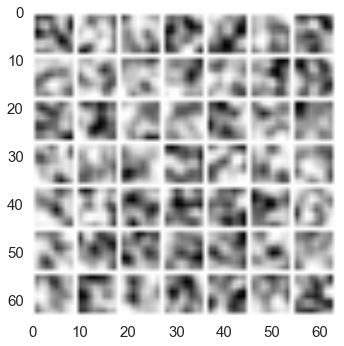

In [9]:
# Visualizing results
A = model.params[0].get_value()
I = grid2d(A)
plt.imshow(I)

Notice that we learned a few Gabor-like wavelets as the filters $mathbf{A}$ just like it was reported at [1]. Usually, those edge detector are usefull as first layer processing for image processing. You'll get stuff like that in the first layer of networks trained to solve Cifar10, Imagenet and pretty much any other good deep learning for image (and something similar for audio as well).

That same SparseCoding layer can be used as part of a classification network. We leave this use case as an exercise for the reader.